# San Ramon Rents Using MXNet

In this tutorial we'll walk through how to predict San Ramon rents using *linear regression* with MXNet.

The rents data is based on <https://sfbay.craigslist.com>


## San Ramon, California

<img height=500 src="https://cdn.tollbrothers.com/communities/12871/images/2880BiancoExterior_920.jpg">

## Prerequisites

To complete this tutorial, we need:  

- jupyter
- scikitlearn
- pandas
- numpy
- matplotlib
- mxnet

## Imports

To begin, the following code imports the necessary packages we'll need for this exercise.

In [1]:
import mxnet as mx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fix the random seed
mx.random.seed(2727)

import logging
logging.getLogger().setLevel(logging.DEBUG)

## Preparing the Data

In MXNet, data is input via **Data Iterators**. Here we will illustrate
how to encode a dataset into an iterator that MXNet can use. The data used in the example is made up of 2D data points with corresponding integer labels. 

In [3]:
# Get the rents as a data frame.
rents_csv = "san-ramon-rents.csv"
df = pd.read_csv(rents_csv)

In [4]:
# Let's take a look at the data.
df.describe()

,rent,br,ft2
count,256.000000,256.000000,256.000000
mean,2787.437500,2.175781,1179.835938
std,878.821057,0.943689,642.734242
min,1800.000000,1.000000,400.000000
25%,2300.000000,2.000000,800.000000
50%,2575.000000,2.000000,953.000000
75%,2961.250000,3.000000,1253.500000
max,9500.000000,5.000000,5200.000000


In [5]:
# Split the data into features (X) and label (y)
label_column = 'rent'
X = df.drop(label_column, axis=1)
y = df[label_column]

# Split data set into training and test sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# Since ft2 is much larger than br we can scale to standardize the features.
scale_features = True
if scale_features:
    # Scale features automatically extracts feature numpy arrays.
    from sklearn import preprocessing
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train = std_scale.transform(X_train)
    X_test = std_scale.transform(X_test)
else:
    # Extract feature numpy arrays.
    X_train = X_train.values
    X_test = X_test.values

# Extract label numpy arrays.
y_train = y_train.values
y_test = y_test.values
        
# How many examples do we train on at a time.
batch_size = 30

Once we have the data ready, we need to put it into an iterator and specify
parameters such as `batch_size` and `shuffle`. `batch_size` specifies the number
of examples shown to the model each time we update its parameters and `shuffle`
tells the iterator to randomize the order in which examples are shown to the model.

In [6]:
train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True, label_name='lin_reg_label')
eval_iter = mx.io.NDArrayIter(X_test, y_test, batch_size, shuffle=False, label_name='lin_reg_label')

In the above example, we have made use of `NDArrayIter`, which is useful for iterating
over both numpy ndarrays and MXNet NDArrays. In general, there are different types of iterators in
MXNet and you can use one based on the type of data you are processing.
Documentation for iterators can be found [here](http://mxnet.io/api/python/io/io.html).

## MXNet Classes

1. **IO:** The IO class as we already saw works on the data and carries out
   operations such as feeding data in batches and shuffling.
   
2. **Symbol:** The actual MXNet neural network is composed using symbols. MXNet has
   different types of symbols, including variable placeholders for input data,
   neural network layers, and operators that manipulate NDArrays.

3. **Module:** The module class in MXNet is used to define the overall computation.
	It is initialized with the model we want to train, the training inputs (data and labels)
	and some additional parameters such as learning rate and the optimization
	algorithm to use.

## Defining the Model

MXNet uses **Symbols** for defining a model. Symbols are the building blocks 
and make up various components of the model. Symbols are used to define:

1. **Variables:** A variable is a placeholder for future data. This symbol is used
   to define a spot which will be filled with training data/labels in the future
   when we commence training.
2. **Neural Network Layers:** The layers of a network or any other type of model are
   also defined by Symbols. Such a symbol takes one or more previous symbols as
   inputs, performs some transformations on them, and creates one or more outputs.
   One such example is the `FullyConnected` symbol which specifies a fully connected
   layer of a neural network.
3. **Outputs:** Output symbols are MXNet's way of defining a loss. They are
   suffixed with the word "Output" (eg. the `SoftmaxOutput` layer). You can also
   [create your own loss function](https://github.com/dmlc/mxnet/blob/master/docs/tutorials/r/CustomLossFunction.md#how-to-use-your-own-loss-function).
   Some examples of existing losses are: `LinearRegressionOutput`, which computes
   the l2-loss between it's input symbol and the labels provided to it;
   `SoftmaxOutput`, which computes the categorical cross-entropy.

The ones described above and other symbols are chained together with the output of
one symbol serving as input to the next to build the network topology. More information
about the different types of symbols can be found [here](http://mxnet.io/api/python/symbol/symbol.html).

In [7]:
X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer  = mx.sym.FullyConnected(data=X, name='fc1', num_hidden = 1)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name="lro")

The above network uses the following layers:

1. `FullyConnected`: The fully connected symbol represents a fully connected layer
   of a neural network (without any activation being applied), which in essence,
   is just a linear regression on the input attributes. It takes the following
   parameters:

   - `data`: Input to the layer (specifies the symbol whose output should be fed here)
   - `num_hidden`: Number of hidden neurons in the layer, which is same as the dimensionality
     of the layer's output

2. `LinearRegressionOutput`: Output layers in MXNet compute training loss, which is
	the measure of inaccuracy in the model's predictions. The goal of training is to minimize the
	training loss. In our example, the `LinearRegressionOutput` layer computes the *l2* loss against
	its input and the labels provided to it. The parameters to this layer are:

   - `data`: Input to this layer (specifies the symbol whose output should be fed here)
   - `label`: The training labels against which we will compare the input to the layer for calculation of l2 loss

## Visualize Network

We can visualize the network we created by plotting it:

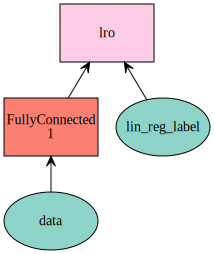

In [8]:
mx.viz.plot_network(symbol=lro)

**Note on naming convention:** the label variable's name should be the same as the
`label_name` parameter passed to your training data iterator. The default value of
this is `softmax_label`, but we have updated it to `lin_reg_label` in this
tutorial as you can see in `Y = mx.symbol.Variable('lin_reg_label')` and
`train_iter = mx.io.NDArrayIter(..., label_name='lin_reg_label')`.


## Module

Finally, the network is input to a *Module*, where we specify the symbol
whose output needs to be minimized (in our case, `lro` or the `lin_reg_output`), the
learning rate to be used while optimization and the number of epochs we want to
train our model for.

In [9]:
# Network structure.
model = mx.mod.Module(
    symbol = lro ,
    data_names=['data'],
    label_names = ['lin_reg_label']
)

In [10]:
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label) 
init = mx.init.Uniform(0.1)
model.init_params(init)

## Training the model

Once we have defined the model structure, the next step is to train the
parameters of the model to fit the training data. This is accomplished using the
`fit()` function of the `Module` class.

Speedometer determines how often we get a callback during training with error data. We will be called every 2 batches if the second argument is 2.

In [11]:
model.fit(train_iter, eval_iter,
            optimizer = "adam",
            optimizer_params = {'learning_rate': 8.0},
            num_epoch=800,
            eval_metric='rmse',
            batch_end_callback = mx.callback.Speedometer(batch_size, 2))

/Users/asimjali/Library/Python/2.7/lib/python/site-packages/mxnet/module/base_module.py:464: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
INFO:root:Epoch[0] Batch [2]	Speed: 14499.78 samples/sec	rmse=2894.669108
INFO:root:Epoch[0] Batch [4]	Speed: 22413.45 samples/sec	rmse=2721.862061
INFO:root:Epoch[0] Train-rmse=2765.838623
INFO:root:Epoch[0] Time cost=0.019
INFO:root:Epoch[0] Validation-rmse=3020.155436
INFO:root:Epoch[1] Batch [2]	Speed: 26501.50 samples/sec	rmse=2845.630615
INFO:root:Epoch[1] Batch [4]	Speed: 28532.68 samples/sec	rmse=2673.041748
INFO:root:Epoch[1] Train-rmse=2710.993652
INFO:root:Epoch[1] Time cost=0.010
INFO:root:Epoch[1] Validation-rmse=2970.152018
INFO:root:Epoch[2] Batch [2]	Speed: 3793.40 samples/sec	rmse=2797.582926
INFO:root:Epoch[2] Batch [4]	Speed: 16184.85 samples/sec	rmse=2624.876465
INFO:root:Epoch[2] Train-rmse=2657.308105
INFO:root:Epoch[2] Time cost

INFO:root:Epoch[28] Validation-rmse=1902.943807
INFO:root:Epoch[29] Batch [2]	Speed: 33165.29 samples/sec	rmse=1714.033244
INFO:root:Epoch[29] Batch [4]	Speed: 22050.14 samples/sec	rmse=1535.499512
INFO:root:Epoch[29] Train-rmse=1544.226929
INFO:root:Epoch[29] Time cost=0.011
INFO:root:Epoch[29] Validation-rmse=1872.246297
INFO:root:Epoch[30] Batch [2]	Speed: 28368.64 samples/sec	rmse=1681.726034
INFO:root:Epoch[30] Batch [4]	Speed: 23838.04 samples/sec	rmse=1502.649536
INFO:root:Epoch[30] Train-rmse=1511.795898
INFO:root:Epoch[30] Time cost=0.012
INFO:root:Epoch[30] Validation-rmse=1842.142253
INFO:root:Epoch[31] Batch [2]	Speed: 32066.54 samples/sec	rmse=1649.998576
INFO:root:Epoch[31] Batch [4]	Speed: 19083.81 samples/sec	rmse=1470.375732
INFO:root:Epoch[31] Train-rmse=1479.948975
INFO:root:Epoch[31] Time cost=0.013
INFO:root:Epoch[31] Validation-rmse=1812.632894
INFO:root:Epoch[32] Batch [2]	Speed: 12177.40 samples/sec	rmse=1618.853231
INFO:root:Epoch[32] Batch [4]	Speed: 26420.81 

INFO:root:Epoch[58] Train-rmse=847.919983
INFO:root:Epoch[58] Time cost=0.010
INFO:root:Epoch[58] Validation-rmse=1237.048686
INFO:root:Epoch[59] Batch [2]	Speed: 33169.66 samples/sec	rmse=1000.616923
INFO:root:Epoch[59] Batch [4]	Speed: 25468.90 samples/sec	rmse=808.881195
INFO:root:Epoch[59] Train-rmse=832.947388
INFO:root:Epoch[59] Time cost=0.009
INFO:root:Epoch[59] Validation-rmse=1223.453837
INFO:root:Epoch[60] Batch [2]	Speed: 32857.85 samples/sec	rmse=985.750448
INFO:root:Epoch[60] Batch [4]	Speed: 19550.83 samples/sec	rmse=793.910095
INFO:root:Epoch[60] Train-rmse=818.548950
INFO:root:Epoch[60] Time cost=0.011
INFO:root:Epoch[60] Validation-rmse=1210.350627
INFO:root:Epoch[61] Batch [2]	Speed: 34620.75 samples/sec	rmse=971.414083
INFO:root:Epoch[61] Batch [4]	Speed: 14244.54 samples/sec	rmse=779.507599
INFO:root:Epoch[61] Train-rmse=804.718201
INFO:root:Epoch[61] Time cost=0.015
INFO:root:Epoch[61] Validation-rmse=1197.730509
INFO:root:Epoch[62] Batch [2]	Speed: 26967.24 sampl

INFO:root:Epoch[88] Train-rmse=606.842651
INFO:root:Epoch[88] Time cost=0.010
INFO:root:Epoch[88] Validation-rmse=1001.959941
INFO:root:Epoch[89] Batch [2]	Speed: 43203.13 samples/sec	rmse=744.803833
INFO:root:Epoch[89] Batch [4]	Speed: 31199.88 samples/sec	rmse=566.268890
INFO:root:Epoch[89] Train-rmse=604.231689
INFO:root:Epoch[89] Time cost=0.010
INFO:root:Epoch[89] Validation-rmse=998.624044
INFO:root:Epoch[90] Batch [2]	Speed: 34225.25 samples/sec	rmse=741.299235
INFO:root:Epoch[90] Batch [4]	Speed: 20905.32 samples/sec	rmse=563.597855
INFO:root:Epoch[90] Train-rmse=601.825867
INFO:root:Epoch[90] Time cost=0.011
INFO:root:Epoch[90] Validation-rmse=995.469808
INFO:root:Epoch[91] Batch [2]	Speed: 27398.83 samples/sec	rmse=737.997660
INFO:root:Epoch[91] Batch [4]	Speed: 26121.88 samples/sec	rmse=561.134262
INFO:root:Epoch[91] Train-rmse=599.613159
INFO:root:Epoch[91] Time cost=0.012
INFO:root:Epoch[91] Validation-rmse=992.488546
INFO:root:Epoch[92] Batch [2]	Speed: 52363.35 samples/s

INFO:root:Epoch[118] Batch [4]	Speed: 24559.21 samples/sec	rmse=538.979172
INFO:root:Epoch[118] Train-rmse=580.403687
INFO:root:Epoch[118] Time cost=0.012
INFO:root:Epoch[118] Validation-rmse=953.257304
INFO:root:Epoch[119] Batch [2]	Speed: 16596.86 samples/sec	rmse=696.030294
INFO:root:Epoch[119] Batch [4]	Speed: 15792.80 samples/sec	rmse=538.937531
INFO:root:Epoch[119] Train-rmse=580.387695
INFO:root:Epoch[119] Time cost=0.016
INFO:root:Epoch[119] Validation-rmse=952.693176
INFO:root:Epoch[120] Batch [2]	Speed: 27025.15 samples/sec	rmse=695.528280
INFO:root:Epoch[120] Batch [4]	Speed: 21061.03 samples/sec	rmse=538.913635
INFO:root:Epoch[120] Train-rmse=580.386719
INFO:root:Epoch[120] Time cost=0.014
INFO:root:Epoch[120] Validation-rmse=952.162150
INFO:root:Epoch[121] Batch [2]	Speed: 43255.11 samples/sec	rmse=695.058695
INFO:root:Epoch[121] Batch [4]	Speed: 21946.30 samples/sec	rmse=538.905533
INFO:root:Epoch[121] Train-rmse=580.399109
INFO:root:Epoch[121] Time cost=0.010
INFO:root:E

INFO:root:Epoch[147] Validation-rmse=945.243754
INFO:root:Epoch[148] Batch [2]	Speed: 27197.48 samples/sec	rmse=689.334513
INFO:root:Epoch[148] Batch [4]	Speed: 22523.78 samples/sec	rmse=540.554993
INFO:root:Epoch[148] Train-rmse=582.170898
INFO:root:Epoch[148] Time cost=0.010
INFO:root:Epoch[148] Validation-rmse=945.142802
INFO:root:Epoch[149] Batch [2]	Speed: 22345.79 samples/sec	rmse=689.258626
INFO:root:Epoch[149] Batch [4]	Speed: 25718.78 samples/sec	rmse=540.613052
INFO:root:Epoch[149] Train-rmse=582.227661
INFO:root:Epoch[149] Time cost=0.012
INFO:root:Epoch[149] Validation-rmse=945.047791
INFO:root:Epoch[150] Batch [2]	Speed: 25178.41 samples/sec	rmse=689.187317
INFO:root:Epoch[150] Batch [4]	Speed: 17559.19 samples/sec	rmse=540.669006
INFO:root:Epoch[150] Train-rmse=582.282288
INFO:root:Epoch[150] Time cost=0.012
INFO:root:Epoch[150] Validation-rmse=944.958293
INFO:root:Epoch[151] Batch [2]	Speed: 37454.72 samples/sec	rmse=689.120443
INFO:root:Epoch[151] Batch [4]	Speed: 26619

INFO:root:Epoch[177] Train-rmse=583.106079
INFO:root:Epoch[177] Time cost=0.013
INFO:root:Epoch[177] Validation-rmse=943.806356
INFO:root:Epoch[178] Batch [2]	Speed: 33169.66 samples/sec	rmse=688.281942
INFO:root:Epoch[178] Batch [4]	Speed: 18576.68 samples/sec	rmse=541.537308
INFO:root:Epoch[178] Train-rmse=583.119324
INFO:root:Epoch[178] Time cost=0.012
INFO:root:Epoch[178] Validation-rmse=943.790751
INFO:root:Epoch[179] Batch [2]	Speed: 33875.12 samples/sec	rmse=688.270793
INFO:root:Epoch[179] Batch [4]	Speed: 27285.94 samples/sec	rmse=541.550430
INFO:root:Epoch[179] Train-rmse=583.131775
INFO:root:Epoch[179] Time cost=0.012
INFO:root:Epoch[179] Validation-rmse=943.776143
INFO:root:Epoch[180] Batch [2]	Speed: 31492.71 samples/sec	rmse=688.260356
INFO:root:Epoch[180] Batch [4]	Speed: 13160.67 samples/sec	rmse=541.562805
INFO:root:Epoch[180] Train-rmse=583.143616
INFO:root:Epoch[180] Time cost=0.014
INFO:root:Epoch[180] Validation-rmse=943.762614
INFO:root:Epoch[181] Batch [2]	Speed: 

INFO:root:Epoch[207] Batch [4]	Speed: 12647.41 samples/sec	rmse=541.720566
INFO:root:Epoch[207] Train-rmse=583.293640
INFO:root:Epoch[207] Time cost=0.013
INFO:root:Epoch[207] Validation-rmse=943.609151
INFO:root:Epoch[208] Batch [2]	Speed: 34502.09 samples/sec	rmse=688.138570
INFO:root:Epoch[208] Batch [4]	Speed: 19493.28 samples/sec	rmse=541.722702
INFO:root:Epoch[208] Train-rmse=583.295715
INFO:root:Epoch[208] Time cost=0.013
INFO:root:Epoch[208] Validation-rmse=943.607808
INFO:root:Epoch[209] Batch [2]	Speed: 36451.08 samples/sec	rmse=688.137410
INFO:root:Epoch[209] Batch [4]	Speed: 24867.42 samples/sec	rmse=541.724701
INFO:root:Epoch[209] Train-rmse=583.297607
INFO:root:Epoch[209] Time cost=0.008
INFO:root:Epoch[209] Validation-rmse=943.606588
INFO:root:Epoch[210] Batch [2]	Speed: 40760.97 samples/sec	rmse=688.136353
INFO:root:Epoch[210] Batch [4]	Speed: 23953.76 samples/sec	rmse=541.726578
INFO:root:Epoch[210] Train-rmse=583.299500
INFO:root:Epoch[210] Time cost=0.010
INFO:root:E

INFO:root:Epoch[236] Validation-rmse=943.603658
INFO:root:Epoch[237] Batch [2]	Speed: 20415.21 samples/sec	rmse=688.129659
INFO:root:Epoch[237] Batch [4]	Speed: 20441.74 samples/sec	rmse=541.752106
INFO:root:Epoch[237] Train-rmse=583.325806
INFO:root:Epoch[237] Time cost=0.014
INFO:root:Epoch[237] Validation-rmse=943.604085
INFO:root:Epoch[238] Batch [2]	Speed: 30814.04 samples/sec	rmse=688.129761
INFO:root:Epoch[238] Batch [4]	Speed: 18149.30 samples/sec	rmse=541.752563
INFO:root:Epoch[238] Train-rmse=583.326355
INFO:root:Epoch[238] Time cost=0.013
INFO:root:Epoch[238] Validation-rmse=943.604553
INFO:root:Epoch[239] Batch [2]	Speed: 18593.15 samples/sec	rmse=688.129924
INFO:root:Epoch[239] Batch [4]	Speed: 11019.28 samples/sec	rmse=541.753006
INFO:root:Epoch[239] Train-rmse=583.326904
INFO:root:Epoch[239] Time cost=0.015
INFO:root:Epoch[239] Validation-rmse=943.605001
INFO:root:Epoch[240] Batch [2]	Speed: 34132.41 samples/sec	rmse=688.130086
INFO:root:Epoch[240] Batch [4]	Speed: 22050

INFO:root:Epoch[266] Train-rmse=583.338989
INFO:root:Epoch[266] Time cost=0.009
INFO:root:Epoch[266] Validation-rmse=943.619812
INFO:root:Epoch[267] Batch [2]	Speed: 35025.50 samples/sec	rmse=688.136169
INFO:root:Epoch[267] Batch [4]	Speed: 26280.10 samples/sec	rmse=541.762451
INFO:root:Epoch[267] Train-rmse=583.339417
INFO:root:Epoch[267] Time cost=0.010
INFO:root:Epoch[267] Validation-rmse=943.620422
INFO:root:Epoch[268] Batch [2]	Speed: 33666.65 samples/sec	rmse=688.136414
INFO:root:Epoch[268] Batch [4]	Speed: 26797.81 samples/sec	rmse=541.762726
INFO:root:Epoch[268] Train-rmse=583.339783
INFO:root:Epoch[268] Time cost=0.010
INFO:root:Epoch[268] Validation-rmse=943.621012
INFO:root:Epoch[269] Batch [2]	Speed: 29572.06 samples/sec	rmse=688.136698
INFO:root:Epoch[269] Batch [4]	Speed: 24001.74 samples/sec	rmse=541.763031
INFO:root:Epoch[269] Train-rmse=583.340210
INFO:root:Epoch[269] Time cost=0.011
INFO:root:Epoch[269] Validation-rmse=943.621582
INFO:root:Epoch[270] Batch [2]	Speed: 

INFO:root:Epoch[296] Batch [4]	Speed: 24008.61 samples/sec	rmse=541.770248
INFO:root:Epoch[296] Train-rmse=583.351013
INFO:root:Epoch[296] Time cost=0.012
INFO:root:Epoch[296] Validation-rmse=943.636637
INFO:root:Epoch[297] Batch [2]	Speed: 22657.62 samples/sec	rmse=688.143555
INFO:root:Epoch[297] Batch [4]	Speed: 24310.11 samples/sec	rmse=541.770508
INFO:root:Epoch[297] Train-rmse=583.351440
INFO:root:Epoch[297] Time cost=0.010
INFO:root:Epoch[297] Validation-rmse=943.637146
INFO:root:Epoch[298] Batch [2]	Speed: 36366.80 samples/sec	rmse=688.143840
INFO:root:Epoch[298] Batch [4]	Speed: 25697.77 samples/sec	rmse=541.770782
INFO:root:Epoch[298] Train-rmse=583.351746
INFO:root:Epoch[298] Time cost=0.011
INFO:root:Epoch[298] Validation-rmse=943.637634
INFO:root:Epoch[299] Batch [2]	Speed: 31795.10 samples/sec	rmse=688.144063
INFO:root:Epoch[299] Batch [4]	Speed: 16731.48 samples/sec	rmse=541.771027
INFO:root:Epoch[299] Train-rmse=583.352112
INFO:root:Epoch[299] Time cost=0.012
INFO:root:E

INFO:root:Epoch[325] Validation-rmse=943.651937
INFO:root:Epoch[326] Batch [2]	Speed: 36018.07 samples/sec	rmse=688.150594
INFO:root:Epoch[326] Batch [4]	Speed: 23556.89 samples/sec	rmse=541.777588
INFO:root:Epoch[326] Train-rmse=583.362427
INFO:root:Epoch[326] Time cost=0.010
INFO:root:Epoch[326] Validation-rmse=943.652364
INFO:root:Epoch[327] Batch [2]	Speed: 33554.43 samples/sec	rmse=688.150818
INFO:root:Epoch[327] Batch [4]	Speed: 14384.58 samples/sec	rmse=541.777847
INFO:root:Epoch[327] Train-rmse=583.362854
INFO:root:Epoch[327] Time cost=0.013
INFO:root:Epoch[327] Validation-rmse=943.652893
INFO:root:Epoch[328] Batch [2]	Speed: 23282.29 samples/sec	rmse=688.151082
INFO:root:Epoch[328] Batch [4]	Speed: 27612.27 samples/sec	rmse=541.778015
INFO:root:Epoch[328] Train-rmse=583.363220
INFO:root:Epoch[328] Time cost=0.012
INFO:root:Epoch[328] Validation-rmse=943.653402
INFO:root:Epoch[329] Batch [2]	Speed: 49142.40 samples/sec	rmse=688.151306
INFO:root:Epoch[329] Batch [4]	Speed: 31250

INFO:root:Epoch[355] Train-rmse=583.373291
INFO:root:Epoch[355] Time cost=0.013
INFO:root:Epoch[355] Validation-rmse=943.666300
INFO:root:Epoch[356] Batch [2]	Speed: 31445.49 samples/sec	rmse=688.157328
INFO:root:Epoch[356] Batch [4]	Speed: 23829.02 samples/sec	rmse=541.784622
INFO:root:Epoch[356] Train-rmse=583.373657
INFO:root:Epoch[356] Time cost=0.011
INFO:root:Epoch[356] Validation-rmse=943.666768
INFO:root:Epoch[357] Batch [2]	Speed: 36813.67 samples/sec	rmse=688.157511
INFO:root:Epoch[357] Batch [4]	Speed: 25928.11 samples/sec	rmse=541.784851
INFO:root:Epoch[357] Train-rmse=583.374084
INFO:root:Epoch[357] Time cost=0.010
INFO:root:Epoch[357] Validation-rmse=943.667236
INFO:root:Epoch[358] Batch [2]	Speed: 30723.75 samples/sec	rmse=688.157694
INFO:root:Epoch[358] Batch [4]	Speed: 21435.97 samples/sec	rmse=541.785049
INFO:root:Epoch[358] Train-rmse=583.374329
INFO:root:Epoch[358] Time cost=0.010
INFO:root:Epoch[358] Validation-rmse=943.667643
INFO:root:Epoch[359] Batch [2]	Speed: 

INFO:root:Epoch[385] Batch [4]	Speed: 25874.79 samples/sec	rmse=541.790924
INFO:root:Epoch[385] Train-rmse=583.383972
INFO:root:Epoch[385] Time cost=0.011
INFO:root:Epoch[385] Validation-rmse=943.679667
INFO:root:Epoch[386] Batch [2]	Speed: 34846.06 samples/sec	rmse=688.163635
INFO:root:Epoch[386] Batch [4]	Speed: 21898.56 samples/sec	rmse=541.791168
INFO:root:Epoch[386] Train-rmse=583.384399
INFO:root:Epoch[386] Time cost=0.012
INFO:root:Epoch[386] Validation-rmse=943.679952
INFO:root:Epoch[387] Batch [2]	Speed: 16629.77 samples/sec	rmse=688.163839
INFO:root:Epoch[387] Batch [4]	Speed: 22471.49 samples/sec	rmse=541.791321
INFO:root:Epoch[387] Train-rmse=583.384766
INFO:root:Epoch[387] Time cost=0.014
INFO:root:Epoch[387] Validation-rmse=943.680440
INFO:root:Epoch[388] Batch [2]	Speed: 31414.09 samples/sec	rmse=688.164022
INFO:root:Epoch[388] Batch [4]	Speed: 21646.16 samples/sec	rmse=541.791565
INFO:root:Epoch[388] Train-rmse=583.385132
INFO:root:Epoch[388] Time cost=0.012
INFO:root:E

INFO:root:Epoch[414] Validation-rmse=943.691284
INFO:root:Epoch[415] Batch [2]	Speed: 22264.73 samples/sec	rmse=688.169352
INFO:root:Epoch[415] Batch [4]	Speed: 22743.63 samples/sec	rmse=541.797195
INFO:root:Epoch[415] Train-rmse=583.394409
INFO:root:Epoch[415] Time cost=0.012
INFO:root:Epoch[415] Validation-rmse=943.691610
INFO:root:Epoch[416] Batch [2]	Speed: 22489.57 samples/sec	rmse=688.169576
INFO:root:Epoch[416] Batch [4]	Speed: 23219.99 samples/sec	rmse=541.797363
INFO:root:Epoch[416] Train-rmse=583.394714
INFO:root:Epoch[416] Time cost=0.011
INFO:root:Epoch[416] Validation-rmse=943.691976
INFO:root:Epoch[417] Batch [2]	Speed: 37178.05 samples/sec	rmse=688.169800
INFO:root:Epoch[417] Batch [4]	Speed: 19627.07 samples/sec	rmse=541.797562
INFO:root:Epoch[417] Train-rmse=583.395081
INFO:root:Epoch[417] Time cost=0.010
INFO:root:Epoch[417] Validation-rmse=943.692403
INFO:root:Epoch[418] Batch [2]	Speed: 38580.14 samples/sec	rmse=688.169983
INFO:root:Epoch[418] Batch [4]	Speed: 25510

INFO:root:Epoch[444] Train-rmse=583.403931
INFO:root:Epoch[444] Time cost=0.011
INFO:root:Epoch[444] Validation-rmse=943.702128
INFO:root:Epoch[445] Batch [2]	Speed: 36340.54 samples/sec	rmse=688.174988
INFO:root:Epoch[445] Batch [4]	Speed: 18343.77 samples/sec	rmse=541.803040
INFO:root:Epoch[445] Train-rmse=583.404236
INFO:root:Epoch[445] Time cost=0.011
INFO:root:Epoch[445] Validation-rmse=943.702515
INFO:root:Epoch[446] Batch [2]	Speed: 33425.19 samples/sec	rmse=688.175151
INFO:root:Epoch[446] Batch [4]	Speed: 31199.88 samples/sec	rmse=541.803207
INFO:root:Epoch[446] Train-rmse=583.404602
INFO:root:Epoch[446] Time cost=0.009
INFO:root:Epoch[446] Validation-rmse=943.702861
INFO:root:Epoch[447] Batch [2]	Speed: 31512.43 samples/sec	rmse=688.175374
INFO:root:Epoch[447] Batch [4]	Speed: 22961.52 samples/sec	rmse=541.803375
INFO:root:Epoch[447] Train-rmse=583.404846
INFO:root:Epoch[447] Time cost=0.011
INFO:root:Epoch[447] Validation-rmse=943.703267
INFO:root:Epoch[448] Batch [2]	Speed: 

INFO:root:Epoch[474] Batch [4]	Speed: 18478.47 samples/sec	rmse=541.808380
INFO:root:Epoch[474] Train-rmse=583.413269
INFO:root:Epoch[474] Time cost=0.011
INFO:root:Epoch[474] Validation-rmse=943.712077
INFO:root:Epoch[475] Batch [2]	Speed: 33558.91 samples/sec	rmse=688.180257
INFO:root:Epoch[475] Batch [4]	Speed: 27533.72 samples/sec	rmse=541.808624
INFO:root:Epoch[475] Train-rmse=583.413635
INFO:root:Epoch[475] Time cost=0.010
INFO:root:Epoch[475] Validation-rmse=943.712402
INFO:root:Epoch[476] Batch [2]	Speed: 33407.44 samples/sec	rmse=688.180440
INFO:root:Epoch[476] Batch [4]	Speed: 18709.26 samples/sec	rmse=541.808746
INFO:root:Epoch[476] Train-rmse=583.413818
INFO:root:Epoch[476] Time cost=0.010
INFO:root:Epoch[476] Validation-rmse=943.712708
INFO:root:Epoch[477] Batch [2]	Speed: 36674.18 samples/sec	rmse=688.180664
INFO:root:Epoch[477] Batch [4]	Speed: 19875.08 samples/sec	rmse=541.808929
INFO:root:Epoch[477] Train-rmse=583.414185
INFO:root:Epoch[477] Time cost=0.013
INFO:root:E

INFO:root:Epoch[503] Validation-rmse=943.720703
INFO:root:Epoch[504] Batch [2]	Speed: 24764.64 samples/sec	rmse=688.185140
INFO:root:Epoch[504] Batch [4]	Speed: 19550.83 samples/sec	rmse=541.813690
INFO:root:Epoch[504] Train-rmse=583.422180
INFO:root:Epoch[504] Time cost=0.013
INFO:root:Epoch[504] Validation-rmse=943.720927
INFO:root:Epoch[505] Batch [2]	Speed: 31559.85 samples/sec	rmse=688.185343
INFO:root:Epoch[505] Batch [4]	Speed: 28330.32 samples/sec	rmse=541.813843
INFO:root:Epoch[505] Train-rmse=583.422485
INFO:root:Epoch[505] Time cost=0.010
INFO:root:Epoch[505] Validation-rmse=943.721212
INFO:root:Epoch[506] Batch [2]	Speed: 28597.53 samples/sec	rmse=688.185445
INFO:root:Epoch[506] Batch [4]	Speed: 22497.61 samples/sec	rmse=541.814056
INFO:root:Epoch[506] Train-rmse=583.422791
INFO:root:Epoch[506] Time cost=0.011
INFO:root:Epoch[506] Validation-rmse=943.721456
INFO:root:Epoch[507] Batch [2]	Speed: 34721.06 samples/sec	rmse=688.185608
INFO:root:Epoch[507] Batch [4]	Speed: 24771

INFO:root:Epoch[533] Train-rmse=583.430237
INFO:root:Epoch[533] Time cost=0.009
INFO:root:Epoch[533] Validation-rmse=943.728638
INFO:root:Epoch[534] Batch [2]	Speed: 40820.48 samples/sec	rmse=688.189880
INFO:root:Epoch[534] Batch [4]	Speed: 27422.71 samples/sec	rmse=541.818756
INFO:root:Epoch[534] Train-rmse=583.430542
INFO:root:Epoch[534] Time cost=0.010
INFO:root:Epoch[534] Validation-rmse=943.728902
INFO:root:Epoch[535] Batch [2]	Speed: 21690.94 samples/sec	rmse=688.190023
INFO:root:Epoch[535] Batch [4]	Speed: 25661.08 samples/sec	rmse=541.818893
INFO:root:Epoch[535] Train-rmse=583.430847
INFO:root:Epoch[535] Time cost=0.012
INFO:root:Epoch[535] Validation-rmse=943.729146
INFO:root:Epoch[536] Batch [2]	Speed: 45083.88 samples/sec	rmse=688.190206
INFO:root:Epoch[536] Batch [4]	Speed: 25043.11 samples/sec	rmse=541.819122
INFO:root:Epoch[536] Train-rmse=583.431091
INFO:root:Epoch[536] Time cost=0.010
INFO:root:Epoch[536] Validation-rmse=943.729390
INFO:root:Epoch[537] Batch [2]	Speed: 

INFO:root:Epoch[563] Batch [4]	Speed: 26549.03 samples/sec	rmse=541.823410
INFO:root:Epoch[563] Train-rmse=583.438171
INFO:root:Epoch[563] Time cost=0.009
INFO:root:Epoch[563] Validation-rmse=943.735819
INFO:root:Epoch[564] Batch [2]	Speed: 38095.40 samples/sec	rmse=688.194458
INFO:root:Epoch[564] Batch [4]	Speed: 21890.94 samples/sec	rmse=541.823563
INFO:root:Epoch[564] Train-rmse=583.438354
INFO:root:Epoch[564] Time cost=0.011
INFO:root:Epoch[564] Validation-rmse=943.736043
INFO:root:Epoch[565] Batch [2]	Speed: 15740.45 samples/sec	rmse=688.194600
INFO:root:Epoch[565] Batch [4]	Speed: 21794.25 samples/sec	rmse=541.823700
INFO:root:Epoch[565] Train-rmse=583.438660
INFO:root:Epoch[565] Time cost=0.013
INFO:root:Epoch[565] Validation-rmse=943.736186
INFO:root:Epoch[566] Batch [2]	Speed: 28737.95 samples/sec	rmse=688.194784
INFO:root:Epoch[566] Batch [4]	Speed: 25872.13 samples/sec	rmse=541.823868
INFO:root:Epoch[566] Train-rmse=583.438843
INFO:root:Epoch[566] Time cost=0.011
INFO:root:E

INFO:root:Epoch[592] Validation-rmse=943.741923
INFO:root:Epoch[593] Batch [2]	Speed: 36631.48 samples/sec	rmse=688.198710
INFO:root:Epoch[593] Batch [4]	Speed: 20491.67 samples/sec	rmse=541.828079
INFO:root:Epoch[593] Train-rmse=583.445618
INFO:root:Epoch[593] Time cost=0.010
INFO:root:Epoch[593] Validation-rmse=943.742106
INFO:root:Epoch[594] Batch [2]	Speed: 33554.43 samples/sec	rmse=688.198812
INFO:root:Epoch[594] Batch [4]	Speed: 15516.26 samples/sec	rmse=541.828232
INFO:root:Epoch[594] Train-rmse=583.445801
INFO:root:Epoch[594] Time cost=0.011
INFO:root:Epoch[594] Validation-rmse=943.742330
INFO:root:Epoch[595] Batch [2]	Speed: 36147.41 samples/sec	rmse=688.198934
INFO:root:Epoch[595] Batch [4]	Speed: 18331.75 samples/sec	rmse=541.828400
INFO:root:Epoch[595] Train-rmse=583.446045
INFO:root:Epoch[595] Time cost=0.014
INFO:root:Epoch[595] Validation-rmse=943.742513
INFO:root:Epoch[596] Batch [2]	Speed: 27274.11 samples/sec	rmse=688.199097
INFO:root:Epoch[596] Batch [4]	Speed: 16441

INFO:root:Epoch[622] Train-rmse=583.452271
INFO:root:Epoch[622] Time cost=0.012
INFO:root:Epoch[622] Validation-rmse=943.747640
INFO:root:Epoch[623] Batch [2]	Speed: 39550.25 samples/sec	rmse=688.202881
INFO:root:Epoch[623] Batch [4]	Speed: 29399.33 samples/sec	rmse=541.832626
INFO:root:Epoch[623] Train-rmse=583.452576
INFO:root:Epoch[623] Time cost=0.010
INFO:root:Epoch[623] Validation-rmse=943.747762
INFO:root:Epoch[624] Batch [2]	Speed: 40760.97 samples/sec	rmse=688.203044
INFO:root:Epoch[624] Batch [4]	Speed: 25695.14 samples/sec	rmse=541.832779
INFO:root:Epoch[624] Train-rmse=583.452759
INFO:root:Epoch[624] Time cost=0.012
INFO:root:Epoch[624] Validation-rmse=943.747925
INFO:root:Epoch[625] Batch [2]	Speed: 36652.82 samples/sec	rmse=688.203145
INFO:root:Epoch[625] Batch [4]	Speed: 28833.44 samples/sec	rmse=541.832932
INFO:root:Epoch[625] Train-rmse=583.453064
INFO:root:Epoch[625] Time cost=0.009
INFO:root:Epoch[625] Validation-rmse=943.748088
INFO:root:Epoch[626] Batch [2]	Speed: 

INFO:root:Epoch[652] Batch [4]	Speed: 23183.62 samples/sec	rmse=541.836884
INFO:root:Epoch[652] Train-rmse=583.458862
INFO:root:Epoch[652] Time cost=0.009
INFO:root:Epoch[652] Validation-rmse=943.752706
INFO:root:Epoch[653] Batch [2]	Speed: 36738.43 samples/sec	rmse=688.206950
INFO:root:Epoch[653] Batch [4]	Speed: 22197.96 samples/sec	rmse=541.836975
INFO:root:Epoch[653] Train-rmse=583.459106
INFO:root:Epoch[653] Time cost=0.010
INFO:root:Epoch[653] Validation-rmse=943.752828
INFO:root:Epoch[654] Batch [2]	Speed: 24884.63 samples/sec	rmse=688.207113
INFO:root:Epoch[654] Batch [4]	Speed: 17953.79 samples/sec	rmse=541.837143
INFO:root:Epoch[654] Train-rmse=583.459229
INFO:root:Epoch[654] Time cost=0.013
INFO:root:Epoch[654] Validation-rmse=943.753011
INFO:root:Epoch[655] Batch [2]	Speed: 30783.88 samples/sec	rmse=688.207255
INFO:root:Epoch[655] Batch [4]	Speed: 24701.44 samples/sec	rmse=541.837296
INFO:root:Epoch[655] Train-rmse=583.459412
INFO:root:Epoch[655] Time cost=0.011
INFO:root:E

INFO:root:Epoch[681] Validation-rmse=943.757060
INFO:root:Epoch[682] Batch [2]	Speed: 24232.86 samples/sec	rmse=688.210775
INFO:root:Epoch[682] Batch [4]	Speed: 13901.47 samples/sec	rmse=541.841171
INFO:root:Epoch[682] Train-rmse=583.465027
INFO:root:Epoch[682] Time cost=0.020
INFO:root:Epoch[682] Validation-rmse=943.757141
INFO:root:Epoch[683] Batch [2]	Speed: 15113.70 samples/sec	rmse=688.210876
INFO:root:Epoch[683] Batch [4]	Speed: 10438.35 samples/sec	rmse=541.841309
INFO:root:Epoch[683] Train-rmse=583.465271
INFO:root:Epoch[683] Time cost=0.018
INFO:root:Epoch[683] Validation-rmse=943.757304
INFO:root:Epoch[684] Batch [2]	Speed: 19531.10 samples/sec	rmse=688.210999
INFO:root:Epoch[684] Batch [4]	Speed: 22925.96 samples/sec	rmse=541.841431
INFO:root:Epoch[684] Train-rmse=583.465454
INFO:root:Epoch[684] Time cost=0.016
INFO:root:Epoch[684] Validation-rmse=943.757467
INFO:root:Epoch[685] Batch [2]	Speed: 20140.72 samples/sec	rmse=688.211182
INFO:root:Epoch[685] Batch [4]	Speed: 14038

INFO:root:Epoch[711] Train-rmse=583.470703
INFO:root:Epoch[711] Time cost=0.012
INFO:root:Epoch[711] Validation-rmse=943.761047
INFO:root:Epoch[712] Batch [2]	Speed: 26571.45 samples/sec	rmse=688.214579
INFO:root:Epoch[712] Batch [4]	Speed: 17426.65 samples/sec	rmse=541.845367
INFO:root:Epoch[712] Train-rmse=583.470886
INFO:root:Epoch[712] Time cost=0.013
INFO:root:Epoch[712] Validation-rmse=943.761169
INFO:root:Epoch[713] Batch [2]	Speed: 37854.73 samples/sec	rmse=688.214762
INFO:root:Epoch[713] Batch [4]	Speed: 21224.44 samples/sec	rmse=541.845520
INFO:root:Epoch[713] Train-rmse=583.471008
INFO:root:Epoch[713] Time cost=0.010
INFO:root:Epoch[713] Validation-rmse=943.761292
INFO:root:Epoch[714] Batch [2]	Speed: 36700.92 samples/sec	rmse=688.214864
INFO:root:Epoch[714] Batch [4]	Speed: 21661.06 samples/sec	rmse=541.845688
INFO:root:Epoch[714] Train-rmse=583.471191
INFO:root:Epoch[714] Time cost=0.014
INFO:root:Epoch[714] Validation-rmse=943.761454
INFO:root:Epoch[715] Batch [2]	Speed: 

INFO:root:Epoch[741] Batch [4]	Speed: 18951.60 samples/sec	rmse=541.849426
INFO:root:Epoch[741] Train-rmse=583.476196
INFO:root:Epoch[741] Time cost=0.011
INFO:root:Epoch[741] Validation-rmse=943.764628
INFO:root:Epoch[742] Batch [2]	Speed: 18662.09 samples/sec	rmse=688.218343
INFO:root:Epoch[742] Batch [4]	Speed: 23383.97 samples/sec	rmse=541.849518
INFO:root:Epoch[742] Train-rmse=583.476318
INFO:root:Epoch[742] Time cost=0.015
INFO:root:Epoch[742] Validation-rmse=943.764791
INFO:root:Epoch[743] Batch [2]	Speed: 25178.41 samples/sec	rmse=688.218424
INFO:root:Epoch[743] Batch [4]	Speed: 14124.61 samples/sec	rmse=541.849655
INFO:root:Epoch[743] Train-rmse=583.476501
INFO:root:Epoch[743] Time cost=0.012
INFO:root:Epoch[743] Validation-rmse=943.764872
INFO:root:Epoch[744] Batch [2]	Speed: 21677.86 samples/sec	rmse=688.218608
INFO:root:Epoch[744] Batch [4]	Speed: 3667.69 samples/sec	rmse=541.849762
INFO:root:Epoch[744] Train-rmse=583.476685
INFO:root:Epoch[744] Time cost=0.027
INFO:root:Ep

INFO:root:Epoch[770] Validation-rmse=943.767761
INFO:root:Epoch[771] Batch [2]	Speed: 24823.26 samples/sec	rmse=688.221842
INFO:root:Epoch[771] Batch [4]	Speed: 22156.91 samples/sec	rmse=541.853333
INFO:root:Epoch[771] Train-rmse=583.481323
INFO:root:Epoch[771] Time cost=0.014
INFO:root:Epoch[771] Validation-rmse=943.767863
INFO:root:Epoch[772] Batch [2]	Speed: 29585.97 samples/sec	rmse=688.221965
INFO:root:Epoch[772] Batch [4]	Speed: 28064.93 samples/sec	rmse=541.853516
INFO:root:Epoch[772] Train-rmse=583.481567
INFO:root:Epoch[772] Time cost=0.010
INFO:root:Epoch[772] Validation-rmse=943.768005
INFO:root:Epoch[773] Batch [2]	Speed: 32484.61 samples/sec	rmse=688.222087
INFO:root:Epoch[773] Batch [4]	Speed: 19697.73 samples/sec	rmse=541.853668
INFO:root:Epoch[773] Train-rmse=583.481689
INFO:root:Epoch[773] Time cost=0.010
INFO:root:Epoch[773] Validation-rmse=943.768046
INFO:root:Epoch[774] Batch [2]	Speed: 30106.26 samples/sec	rmse=688.222249
INFO:root:Epoch[774] Batch [4]	Speed: 21779

## Using a trained model: (Testing and Inference)

Once we have a trained model, we can do a couple of things with it - we can either
use it for inference or we can evaluate the trained model on test data. The latter is shown below:

RMSE = 1222.33213909
MAPE = 20.0%
Accuracy = 80.0%


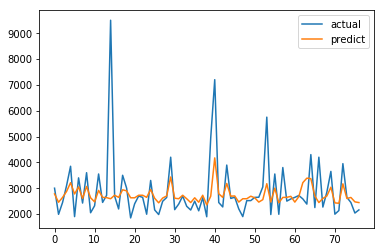

In [12]:
# Let's find out how we did.
y_predict = model.predict(eval_iter).asnumpy()

# RMSE is Root Mean Square Error.
rmse = np.sqrt(np.mean((y_predict - y_test)**2))
print('RMSE = {}'.format(rmse))

# MAPE is Median Absolute Percentage Error.
mape = 100 * np.median(np.abs(y_test - y_predict) / y_test)
print('MAPE = {}%'.format(round(mape, 2)))

# Accuracy is the opposite of MAPE.
accuracy = 100 - mape
print('Accuracy = {}%'.format(round(accuracy, 2)))

# Plot the predictions against the actual values.
plt.plot(np.array(y_test), label='actual')
plt.plot(y_predict, label='predict')
plt.legend()
plt.show()